In [1]:
# Main library: https://square.github.io/pysurvival/index.html
#----------------------------Reproducible------------------------------------------
import numpy as np
import random as rn
import pandas as pd
import gc
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)

#----------------------------Reproducible------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.display import compare_to_actual

from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

import heapq
import seaborn as sns

In [2]:
def csv_read(p_path):
    pd_data=pd.read_csv(p_path, sep=',')
    column_names=pd_data.columns.values.tolist()
    print(column_names)
    return pd_data,column_names

def write_to_csv(p_data,p_path):
    dataframe = pd.DataFrame(p_data)
    dataframe.to_csv(p_path, mode='a',header=False,index=False,sep=',')
    del dataframe
    gc.collect()

In [3]:
data,column_names=csv_read('./data/survival_data_filtered_3.csv')

['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'INBIRMO', 'INBIRYR', 'INSEX', 'NACCNINR', 'INRELTO', 'INLIVWTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCFAM', 'NACCMOM', 'NACCDAD', 'NACCFADM', 'NACCFFTD', 'NACCSTYR', 'NACCTIYR', 'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE', 'CDRSUM', 'DECSUB', 'DECIN', 'COGMEM', 'COGJUDG', 'COGLANG', 'COGVIS', 'COGATTN', 'COGOTHR', 'NACCCOGF', 'COGMODE', 'DECAGE', 'BEAPATHY', 'BEDEP', 'BEVHALL', 'BEAHALL', 'BEDEL', 'BEDISIN', 'BEIRRIT', 'BEAGIT', 'BEPERCH', 'BEOTHR', 'NACCBEHF', 'BEMODE', 'MOGAIT', 'MOFALLS', 'MOTREM', 'MOSLOW', 'NACCMOTF', 'MOMODE', 'COURSE', 'FRSTCHG', 'NORMCOG', 'DEMENTED', 'NACCPPA', 'NACCBVFT', 'NACCLBDS', 'NACCTMCI', 'NACCMCIL', 'NACCMCIA', 'NACCMCIE', 'NACCMCIV', 'NACCMCII', 'IMPNOMCI', 'NACCALZD', 'NACCALZP', 'NACCLBDE', 'NACCLBDP', 'PARK', 'PSP', 'PSPIF', 'CORT', 'CORTIF', '

In [4]:
data

,NACCREAS,NACCREFR,BIRTHMO,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,...,NPBNKB,NACCFORM,NACCPARA,NACCCSFP,NPBNKF,NPFAUT,NACCDAGE,NACCINT,SurvivalTime,Event
0,0,2,3,10,1,0,3,0,2,2,...,1,1,1,1,0,0,41,4,305,False
1,1,1,9,35,1,0,3,0,2,2,...,1,1,1,0,0,0,15,33,97,True
2,0,1,7,20,1,0,3,0,2,2,...,0,1,1,0,0,0,26,2,0,False
3,1,0,6,27,0,0,3,0,2,2,...,1,1,1,0,0,0,19,80,0,False
4,0,2,4,20,0,0,3,0,2,2,...,0,1,1,0,0,0,31,43,148,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,0,0,4,40,0,0,3,0,2,2,...,0,1,1,1,0,0,11,36,262,False
427,0,1,4,43,1,0,3,0,2,2,...,1,1,1,0,0,0,9,78,132,False
428,1,1,6,13,1,0,3,0,1,2,...,1,1,1,0,0,0,39,3,31,True
429,2,1,8,40,0,0,3,0,2,2,...,1,0,1,0,0,0,10,12,0,False


In [5]:
Events=np.array(data.loc[:,'Event'])
print("%.2f%% samples are right censored in whole data." % (np.sum(~Events) * 100. / len(Events)))

50.12% samples are right censored in whole data.


In [6]:
Events

array([False,  True, False, False,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True, False, False,
       False, False,  True,  True, False, False, False, False, False,
        True, False,  True, False, False, False, False, False,  True,
        True, False,  True,  True, False,  True, False,  True,  True,
       False, False,  True, False, False, False,  True,  True,  True,
        True, False, False,  True, False,  True,  True,  True, False,
        True, False,  True,  True, False,  True, False,  True,  True,
        True, False, False,  True,  True, False,  True, False,  True,
        True,  True,  True, False, False,  True,  True, False, False,
        True, False, False,  True, False, False,  True,  True, False,
        True, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False,  True, False,  True,  True,
        True, False,  True, False, False, False, False, False, False,
        True,  True,

In [ ]:
X=data.loc[:,'NACCREAS':'NACCINT']
y_=data.loc[:,'SurvivalTime':'Event']
y=np.array([(y__[1],y__[0]) for y__ in np.array(y_)], dtype=[('Event', 'bool'), ('SurvivalTime', '<f8')])

models=[]
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
seed_num=15
epoch_num=2000

for seed_i in np.arange(seed_num):

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=seed_i)

    time_train=y_train['SurvivalTime']
    event_train=y_train['Event']
    time_test=y_test['SurvivalTime']
    event_test=y_test['Event']

    # Building the model
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_train, time_train, event_train, num_epochs = epoch_num,lr=1e-4, init_method='glorot_uniform')

    models.append(nonlinear_coxph)

% Completion: 100%|***********************************************|Loss: 510.72
% Completion: 100%|***********************************************|Loss: 541.71


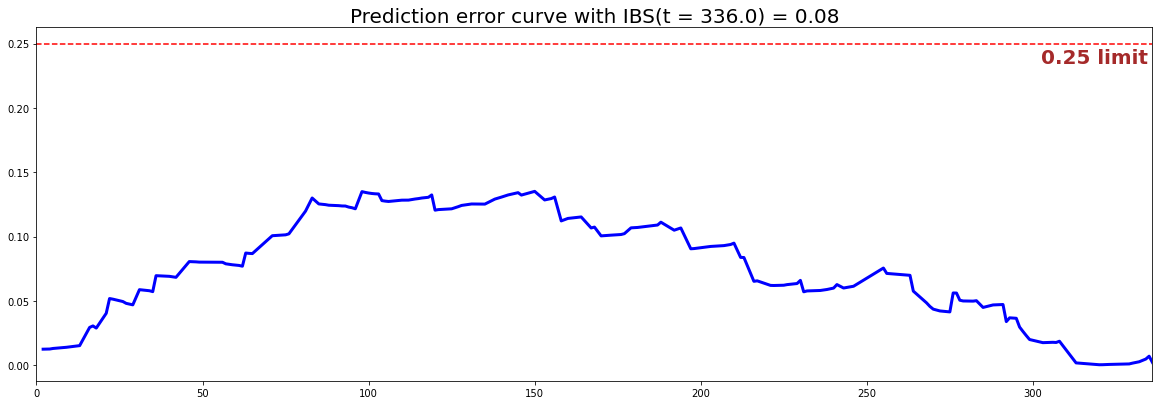

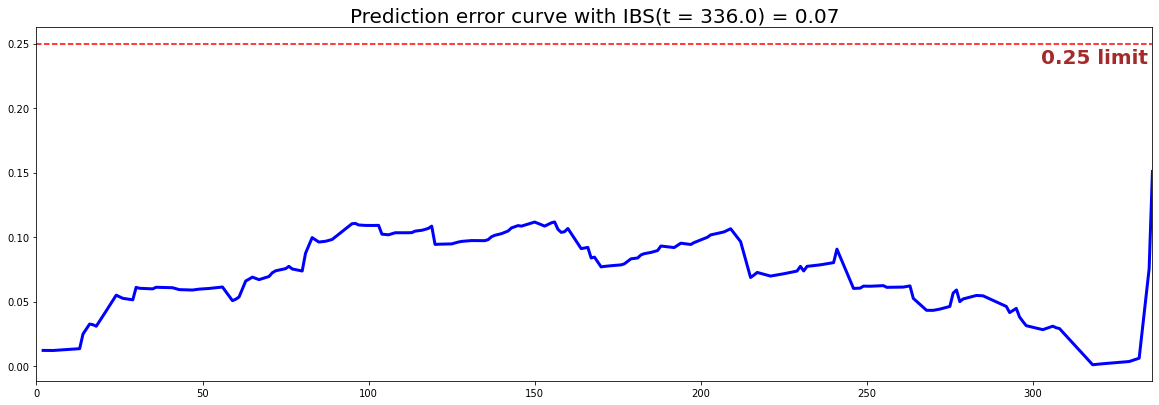

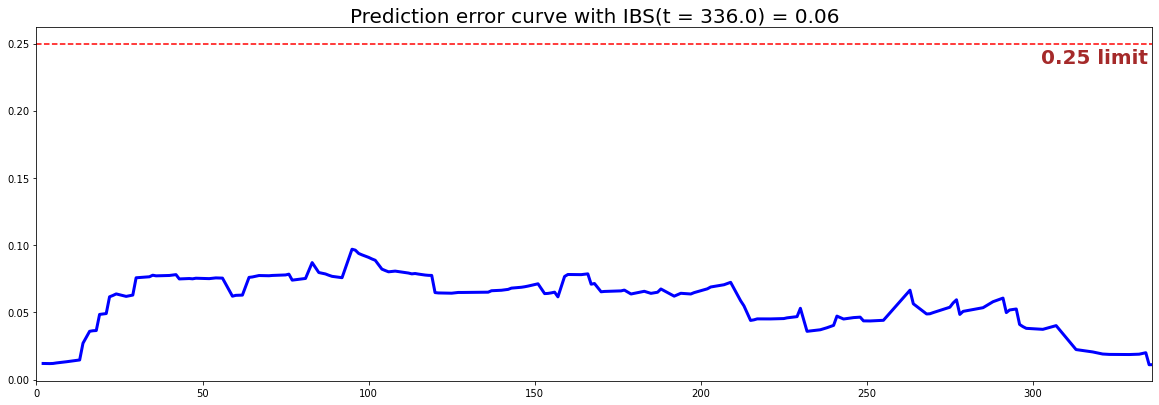

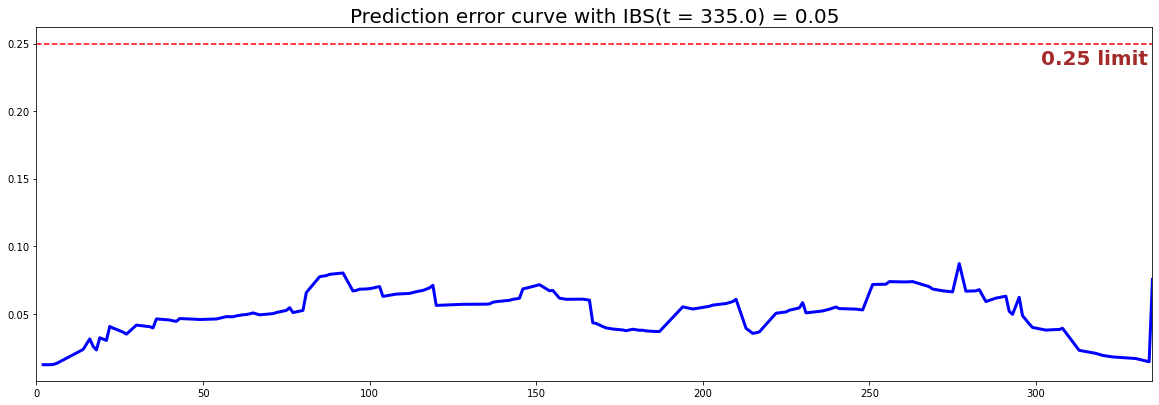

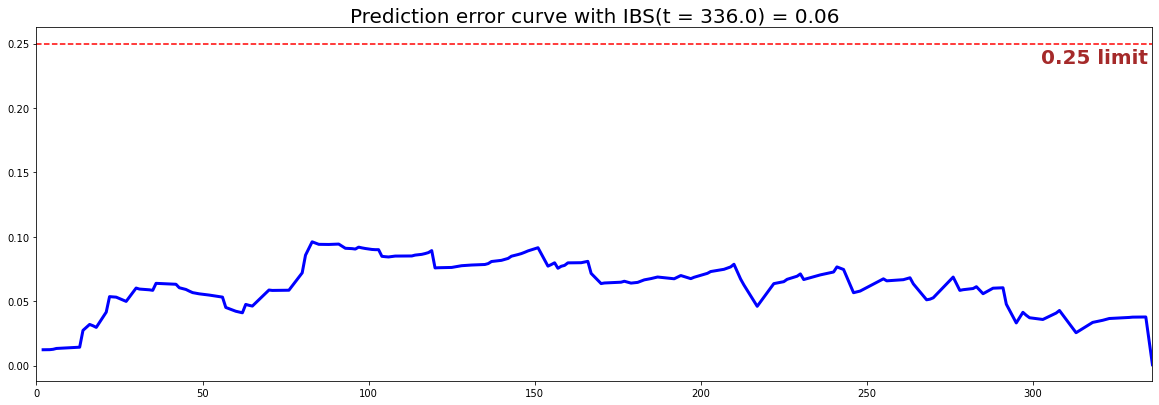

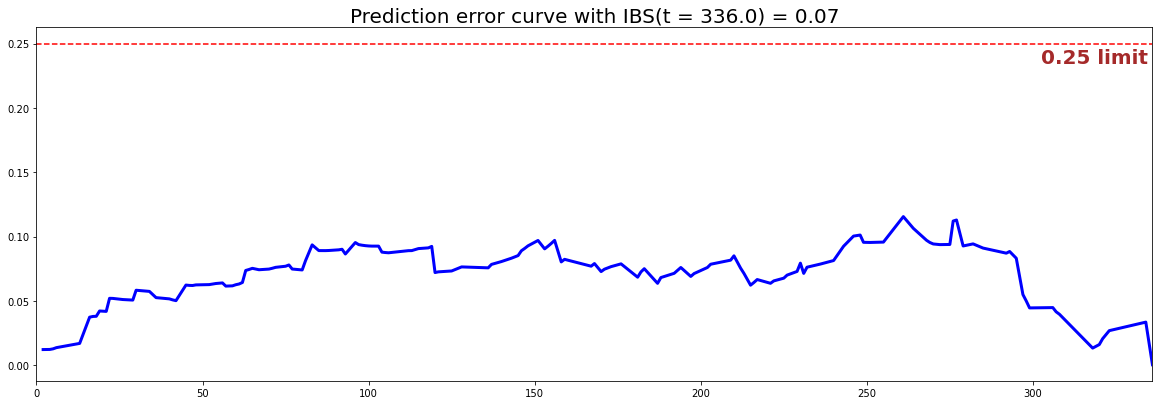

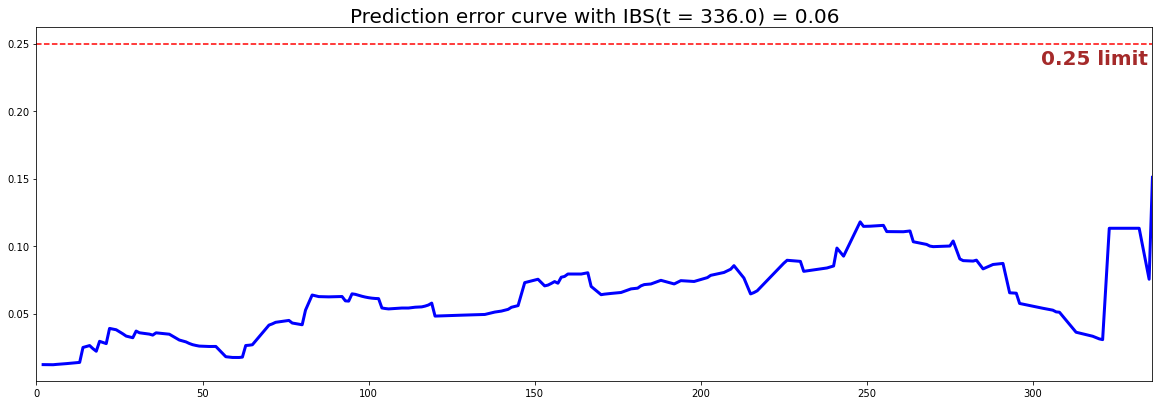

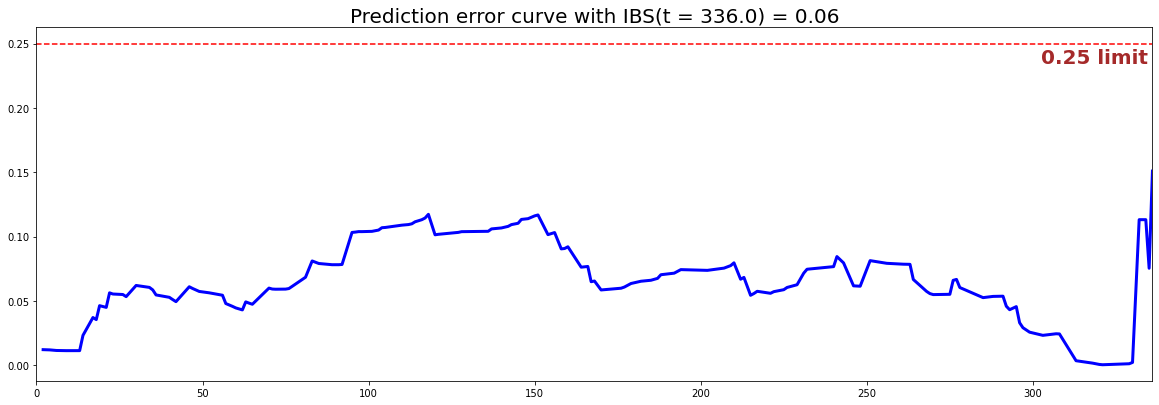

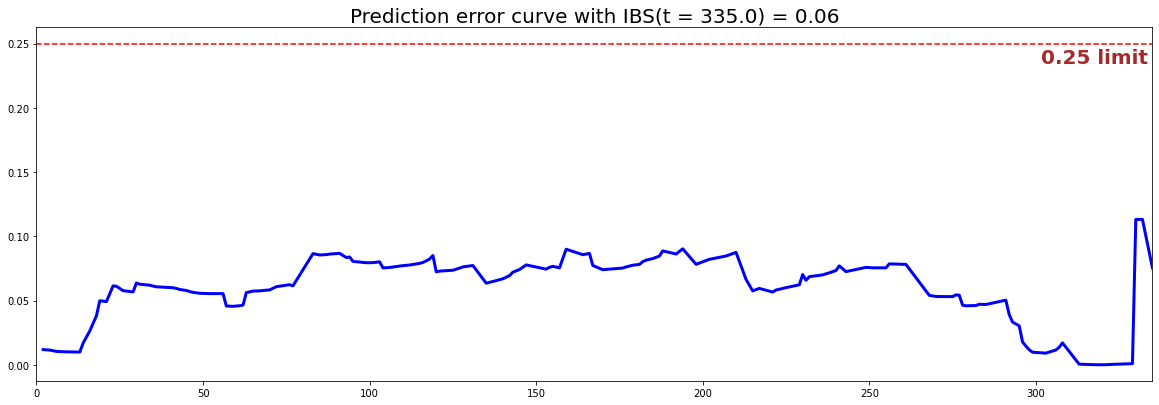

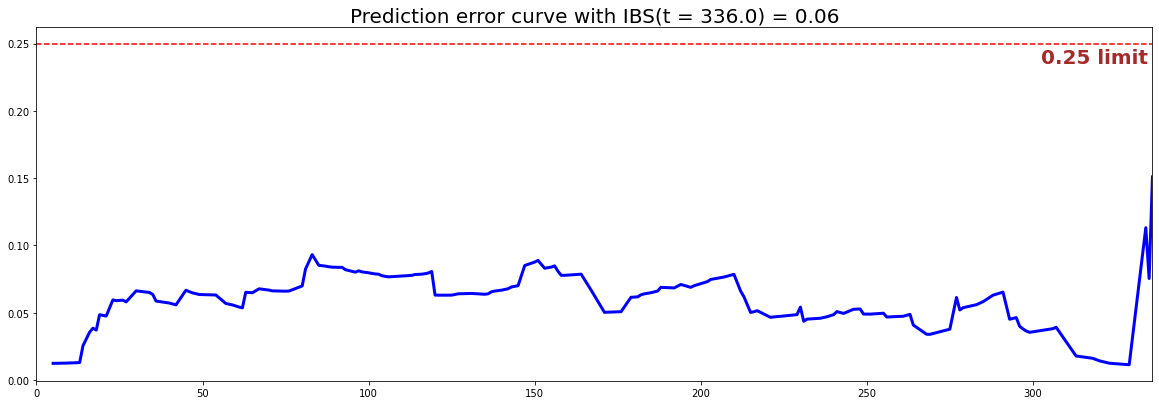

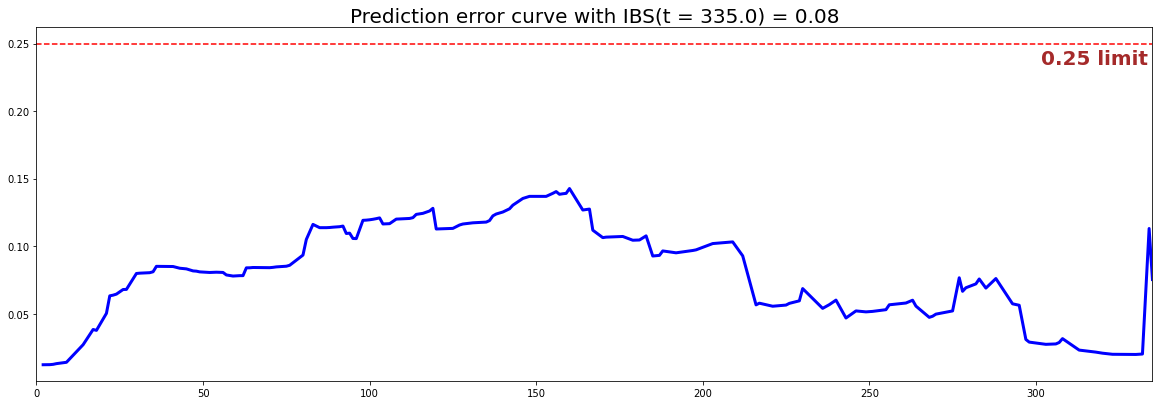

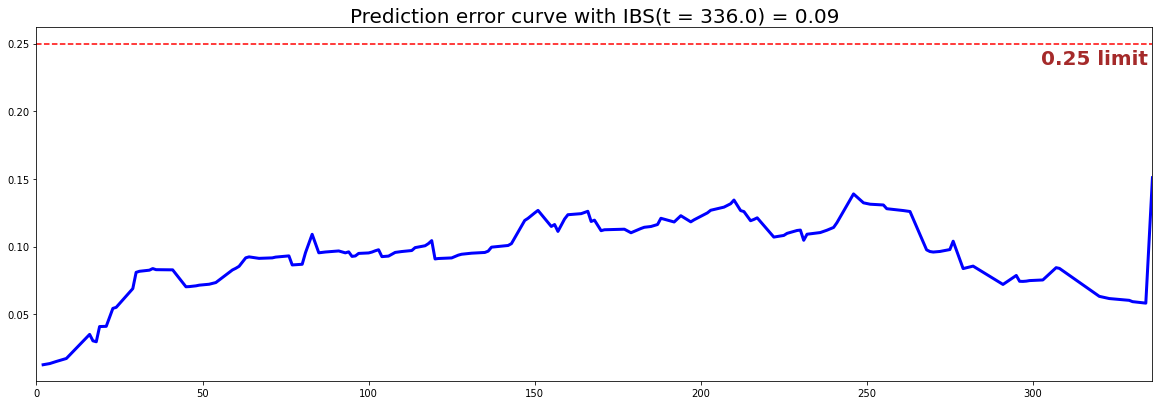

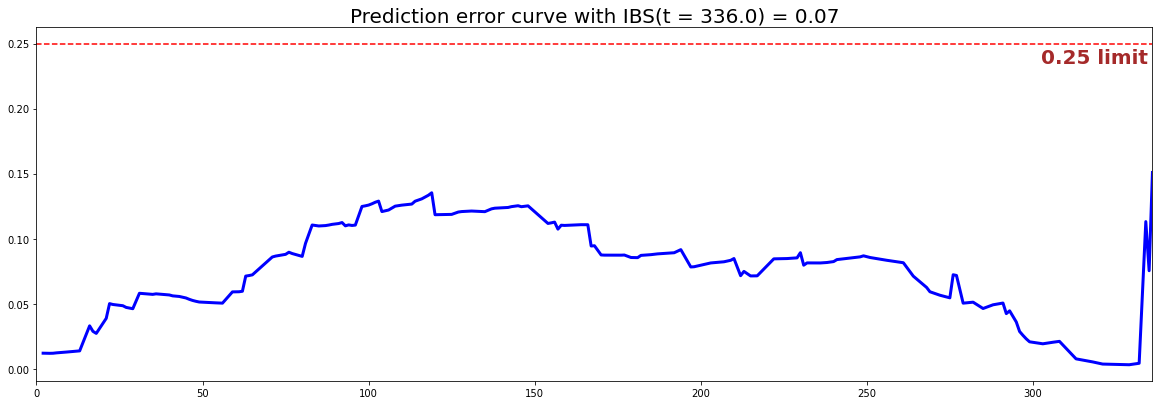

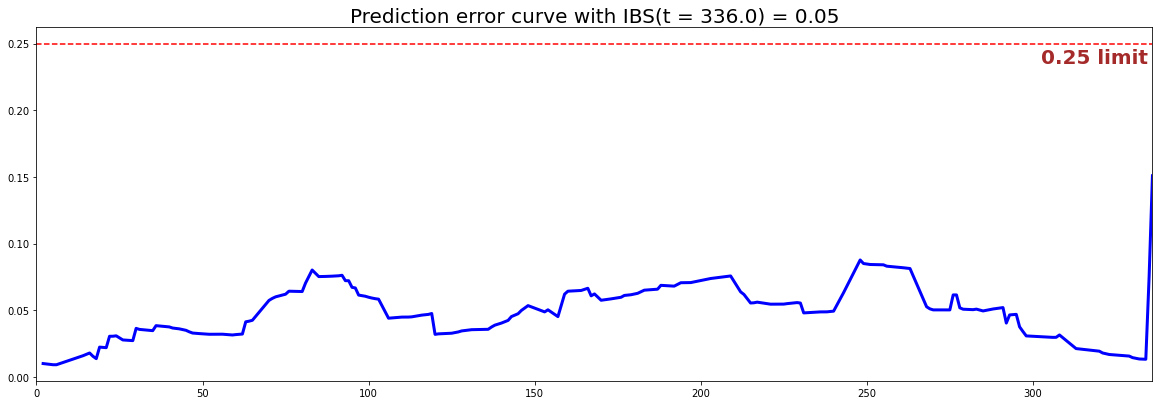

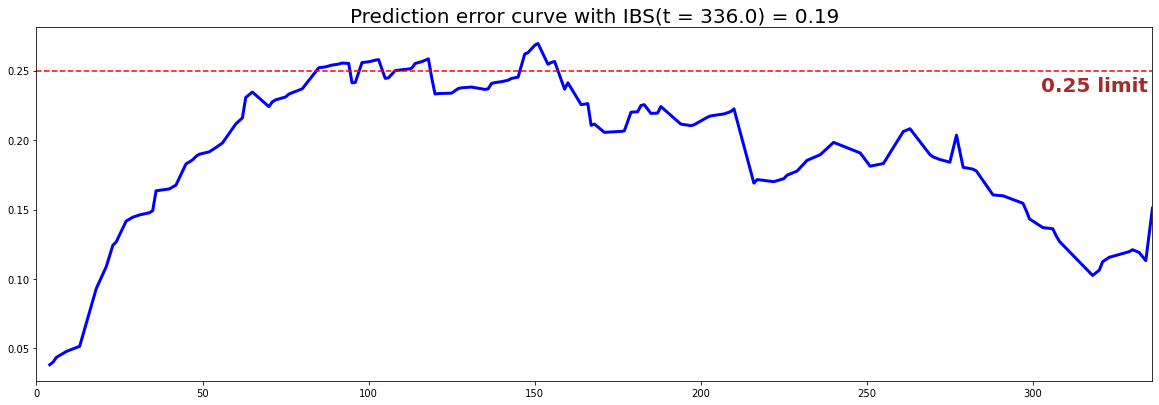

In [9]:
Loss_list=[]
C_index_list=[]
IBS_list=[]

for seed_i in np.arange(seed_num):
    model_used=models[seed_i]
    Loss_list.append(model_used.loss_values)
    
    # Model Performances
    c_index = concordance_index(model_used, X_test, time_test, event_test) #0.81
    #print('C-index: {:.2f}'.format(c_index))

    ibs = integrated_brier_score(model_used, X_test, time_test, event_test, t_max=None, figure_size=(20, 6.5) )
    #print('IBS: {:.2f}'.format(ibs))

    C_index_list.append(c_index)
    IBS_list.append(ibs)

In [10]:
p_path="./performance_CI.csv"
write_to_csv(np.array(C_index_list).reshape(1,np.array(C_index_list).shape[0]),p_path)
print(C_index_list)
print(np.mean(C_index_list))
print(np.std(C_index_list))

p_path="./performance_IBS.csv"
write_to_csv(np.array(IBS_list).reshape(1,np.array(IBS_list).shape[0]),p_path)
print(IBS_list)
print(np.mean(IBS_list))
print(np.std(IBS_list))

[0.8717100456216975, 0.8808637680320773, 0.9056777755756886, 0.9155859463801591, 0.8975144740978229, 0.879621649860053, 0.8901526058402175, 0.8920549519781837, 0.9017890241705889, 0.9088032108000418, 0.8701451240816382, 0.84321945787396, 0.8647076671009052, 0.9213254315591488, 0.7061029058275767]
0.8766182692533172
0.04987657589460384
[0.07620151458256127, 0.06865674405668498, 0.057681318816269575, 0.050623159937980826, 0.061629650770118914, 0.07026682506457177, 0.0630767954015432, 0.06489646108203852, 0.060228163912951264, 0.05686928805896496, 0.07915843187230799, 0.09354913294418062, 0.07418302671165622, 0.048417352867586624, 0.18942553012666644]
0.07432422641373888
0.03274467924996749


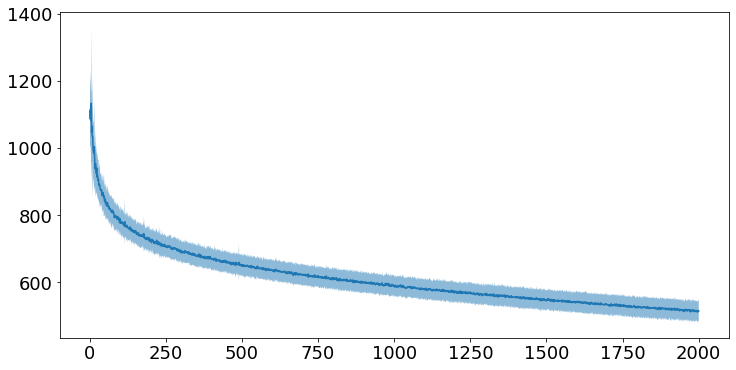

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
Loss_list_mean=np.mean(np.array(Loss_list),axis=0)
Loss_list_std=np.std(np.array(Loss_list),axis=0)

max_loss=int(np.max(Loss_list_mean))+1
min_loss=int(np.min(Loss_list_mean))
step=int(max_loss/5)

ax.plot(np.arange(epoch_num)+1, Loss_list_mean, '-')
ax.fill_between(np.arange(epoch_num)+1, Loss_list_mean - Loss_list_std, Loss_list_mean + Loss_list_std, alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

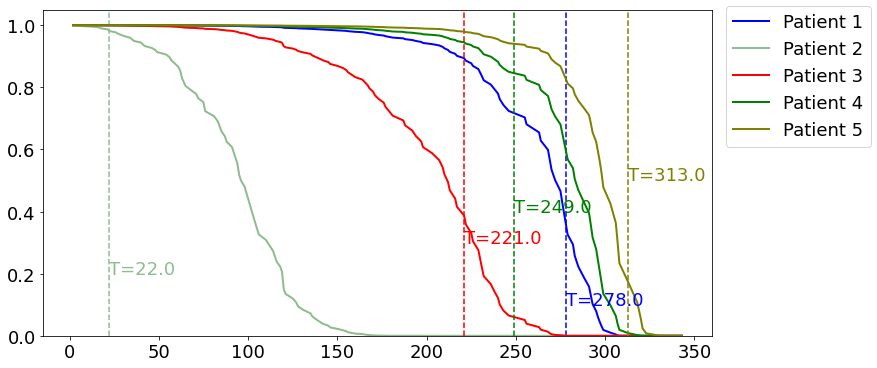

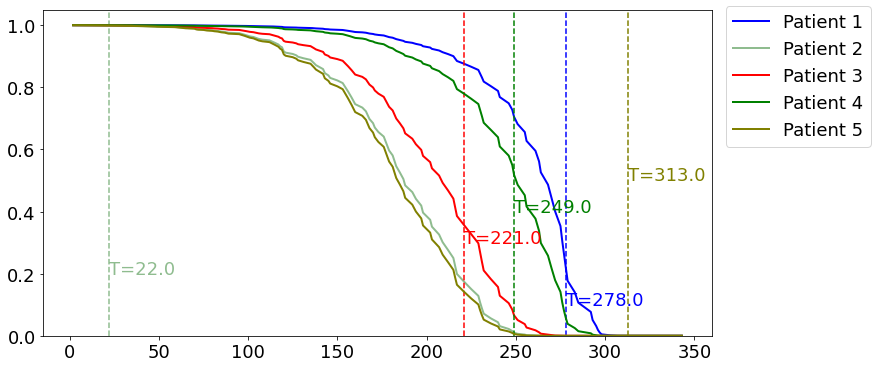

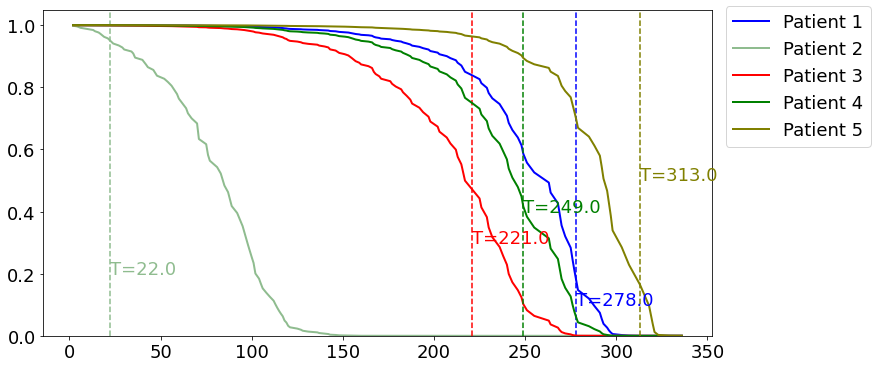

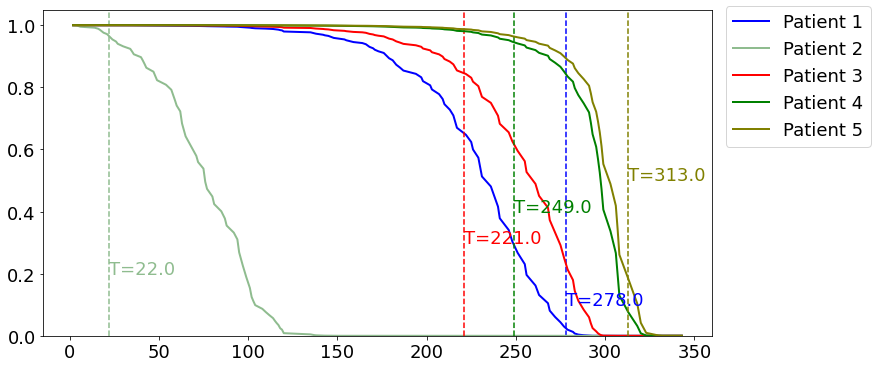

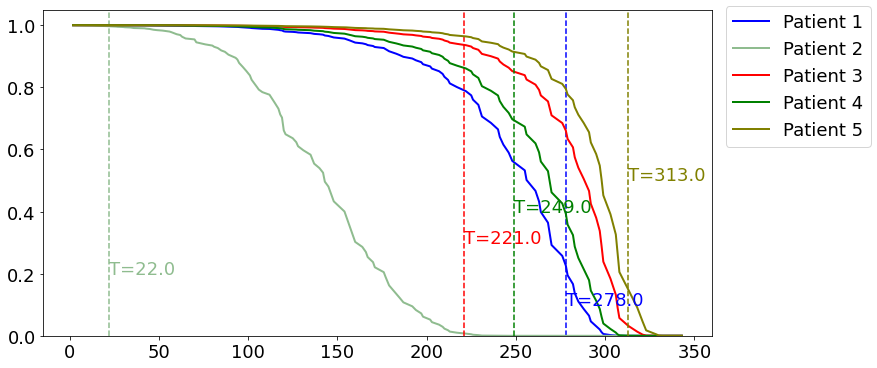

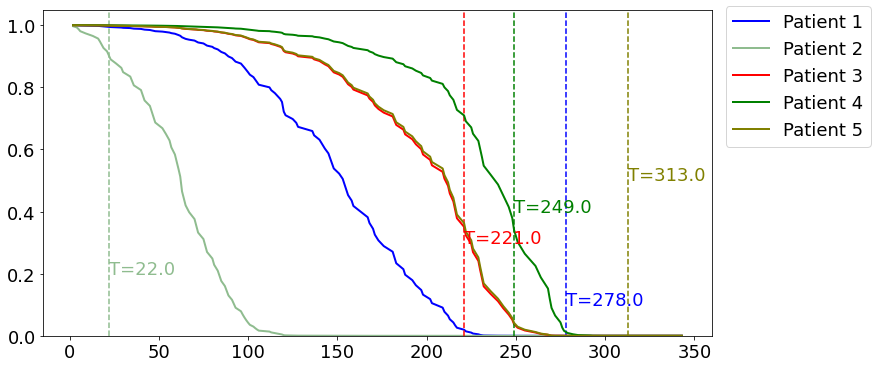

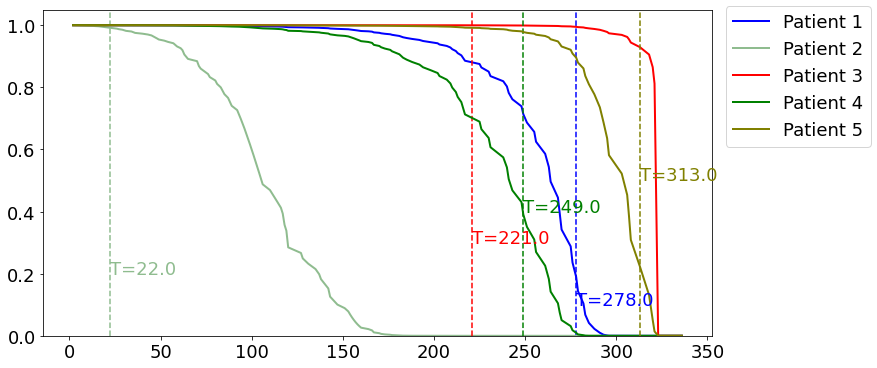

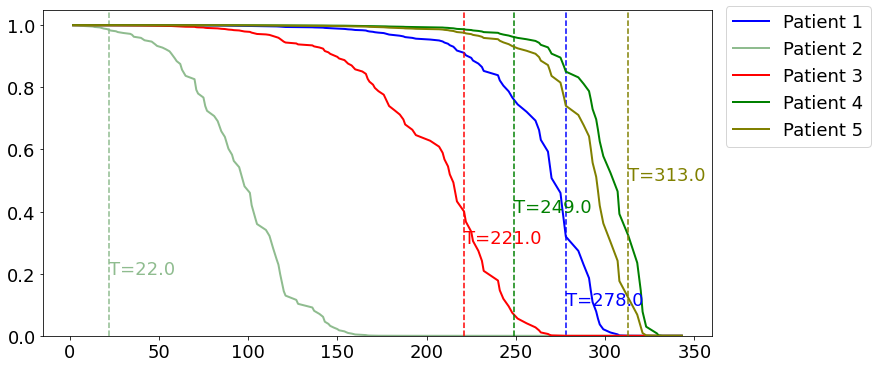

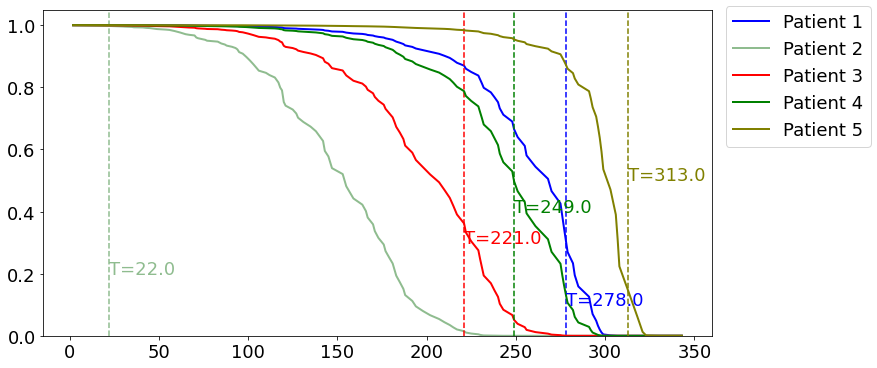

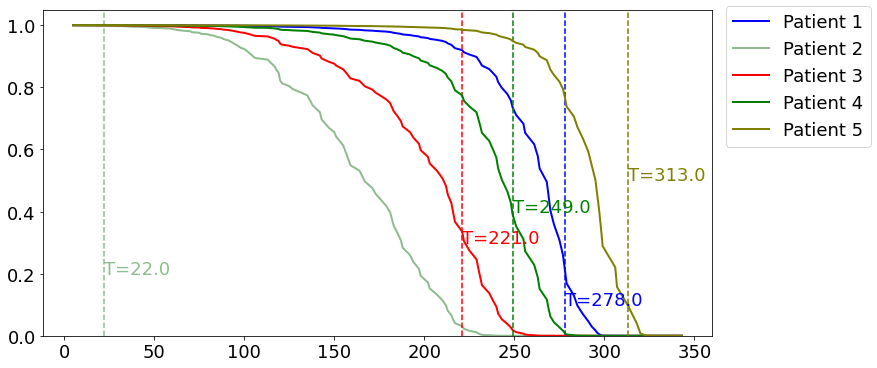

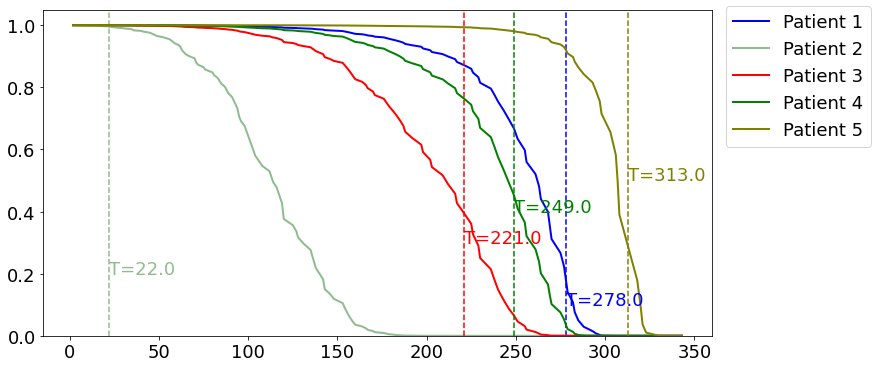

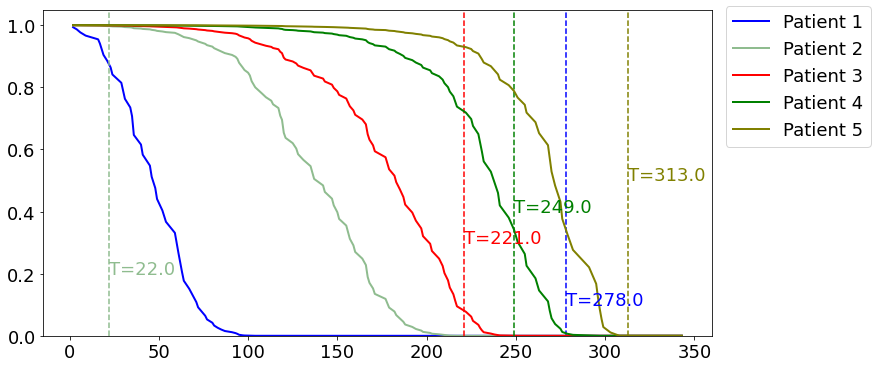

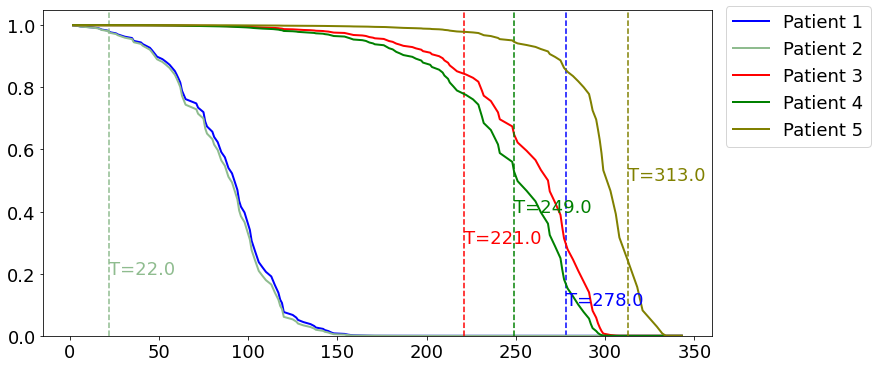

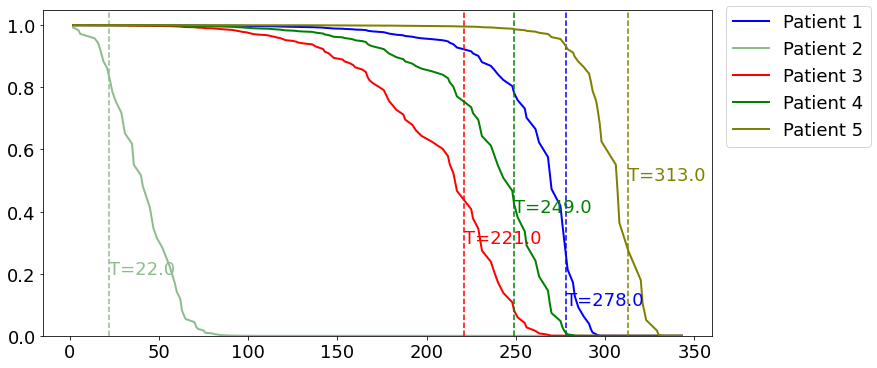

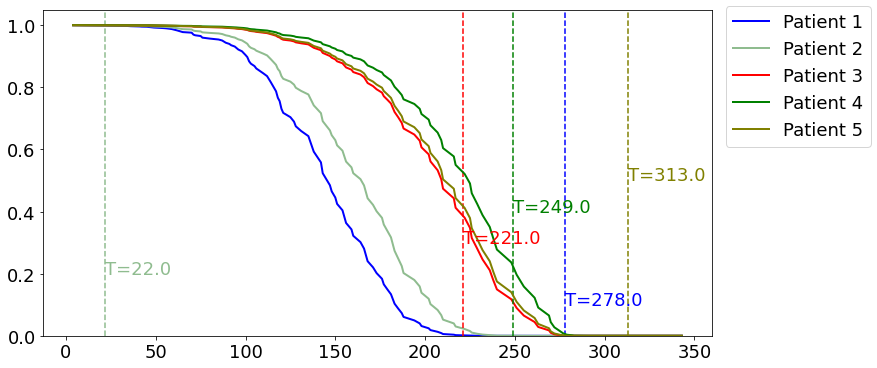

In [12]:
cs=['blue','darkseagreen','red','green','olive','cyan','tan','silver','purple','fuchsia','chocolate','darkcyan','aqua','pink','orange','bisque','lightsteelblue']

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 5,replace=False)

for seed_i in np.arange(seed_num):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Saving the time of event
    for i in np.arange(len(k_list)):
        k=k_list[i]
        t = time_test[k]

        # Computing the Survival function for all times t
        predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

        # Displaying the functions
        plt.plot(models[seed_i].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
        # Actual time
        plt.axvline(x=t, color=cs[i], ls ='--')
        ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, (0.1+i/10)), fontsize=18,color=cs[i])

    plt.legend(loc=[1.02,0.58],fontsize=18, ncol=1)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

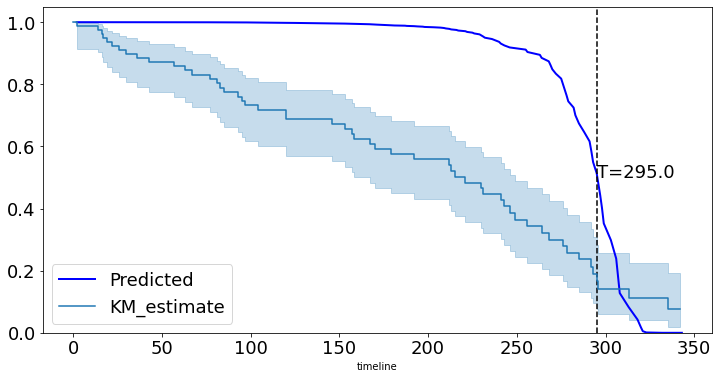

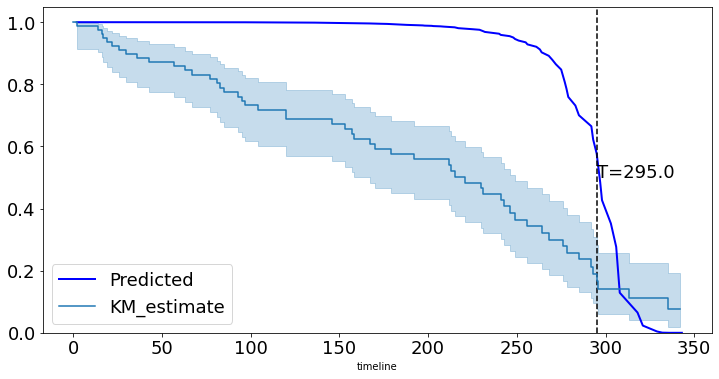

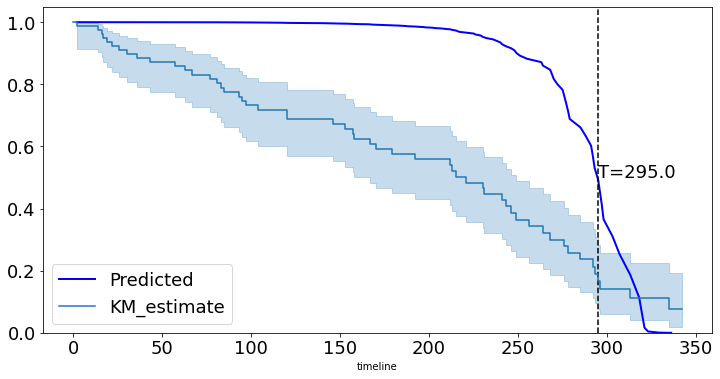

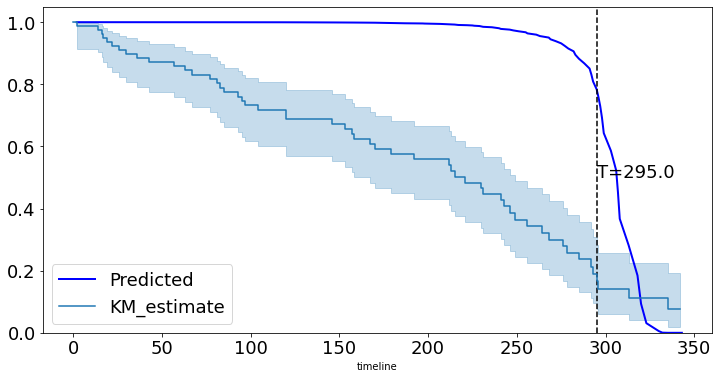

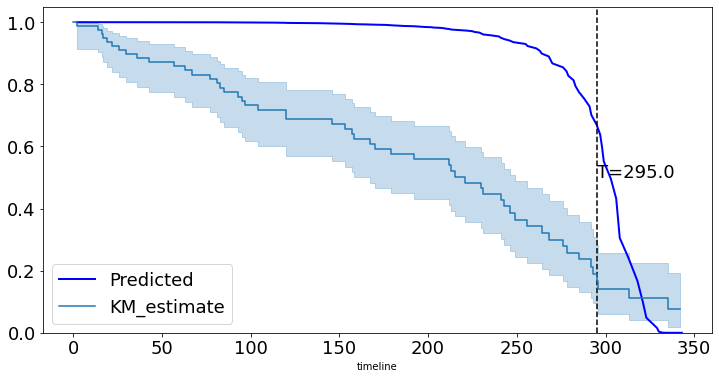

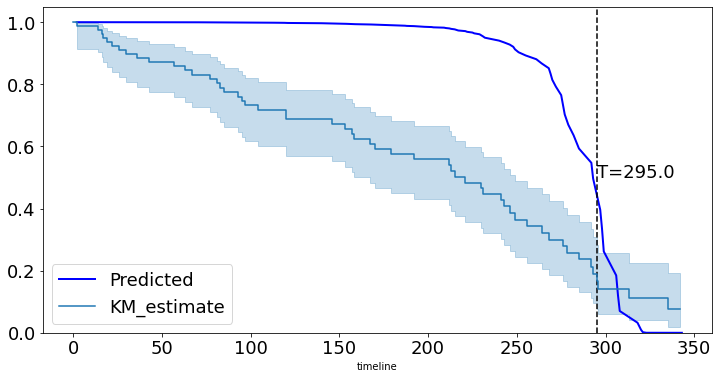

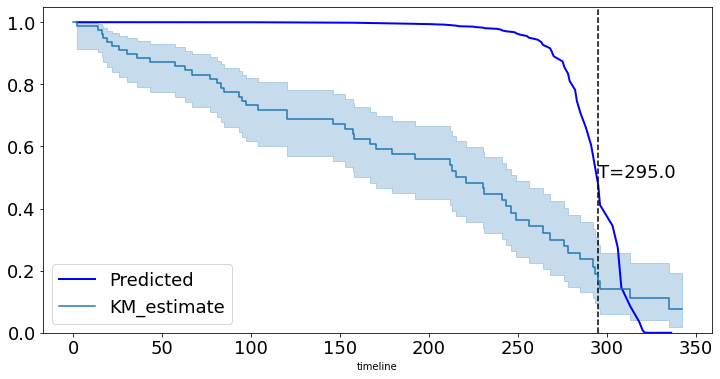

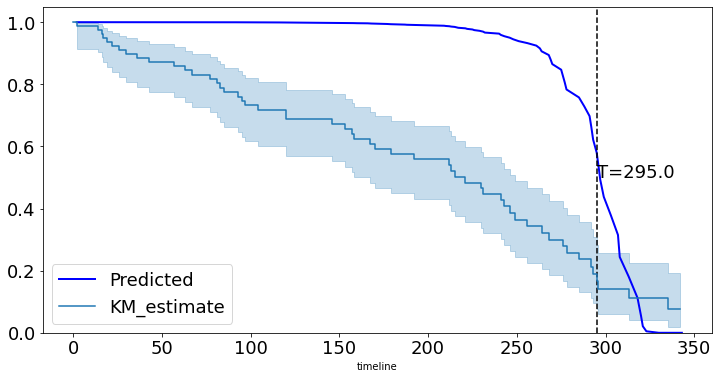

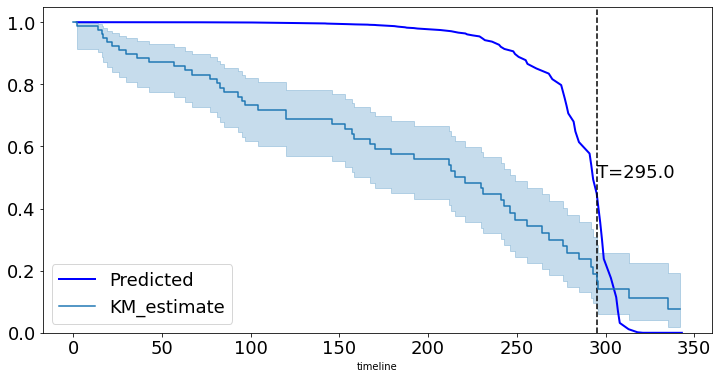

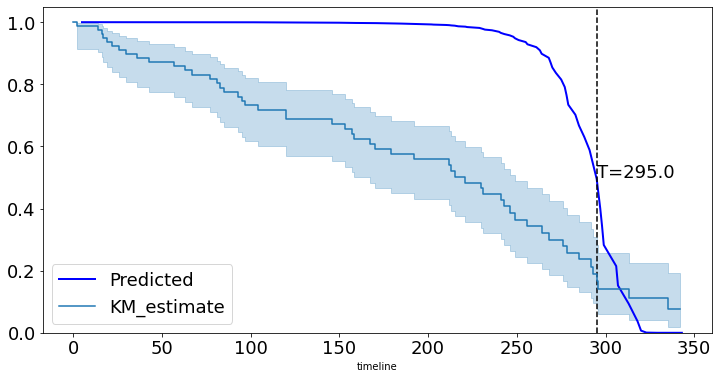

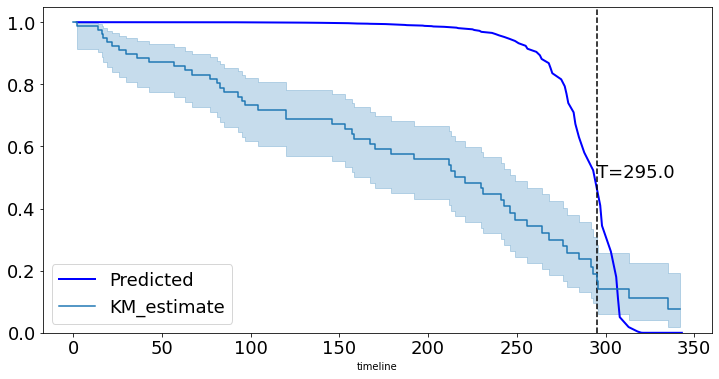

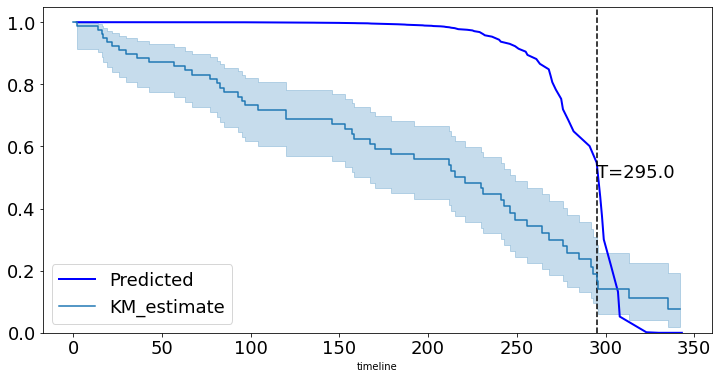

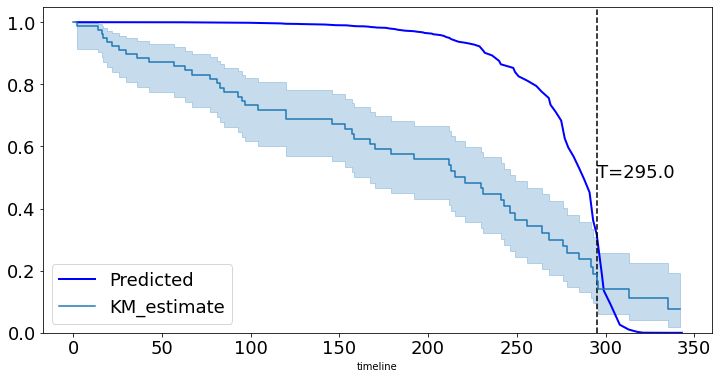

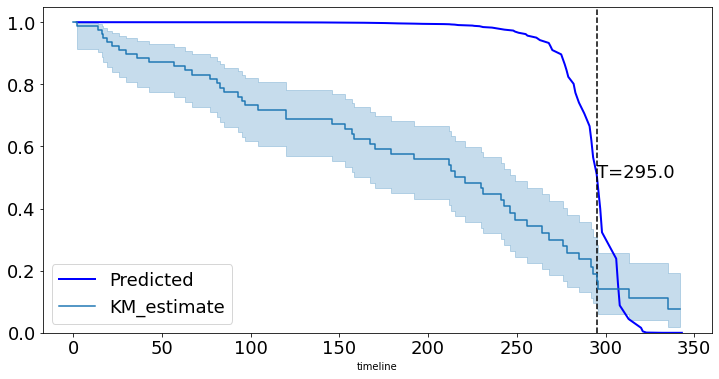

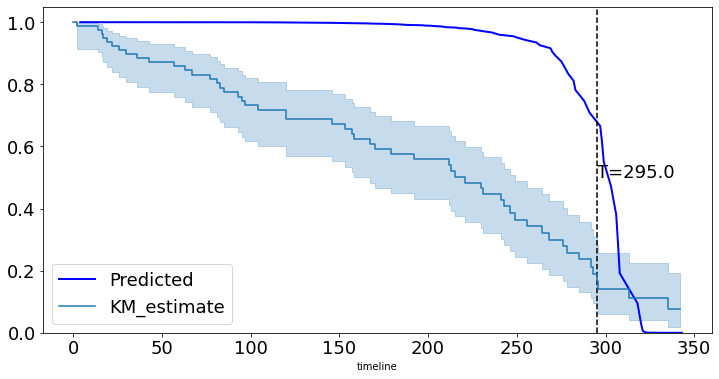

In [13]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]
    
for seed_i in np.arange(seed_num):
    
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(12, 6))

    # Saving the time of event
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[seed_i].times, predicted, color='blue', label='Predicted', lw=2)

    # Actual time
    plt.axvline(x=t, color='black', ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

    kmf.fit(time_test, event_observed=event_test)
    ax = kmf.plot_survival_function(ax=ax)

    # Show everything
    plt.legend(fontsize=18)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [14]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice(choices, 1)[0]

# Saving the time of event
t = time_test[k]

predicted_list=[]
time_set={'Nan'}

for seed_i in np.arange(seed_num):
    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()
    time=models[seed_i].times

    predicted_list.append(dict(zip(time,predicted)))
    time_set.update(set(time))

average_time_predicted_dict={}
for time_set_i in time_set:
    predicted_value=[]
    for seed_i in np.arange(seed_num):
        if time_set_i in predicted_list[seed_i].keys():
            predicted_value.append(predicted_list[seed_i][time_set_i])
    if len(predicted_value)>0:
        average_time_predicted_dict[time_set_i]=[np.mean(predicted_value),np.std(predicted_value)]
        
average_time_predicted={}
for i in sorted (average_time_predicted_dict.keys()) : 
    average_time_predicted[i]=average_time_predicted_dict[i]

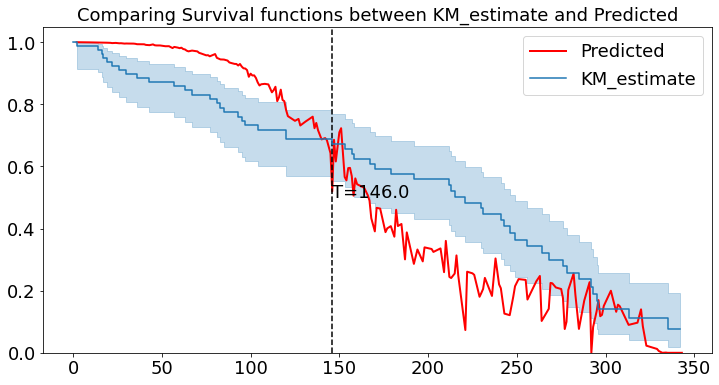

In [15]:
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 6))

# Displaying the functions
plt.plot(list(average_time_predicted.keys()), np.array(list(average_time_predicted.values()))[:,0], color='red', label='Predicted', lw=2)

# Actual time
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

kmf.fit(time_test, event_observed=event_test)
ax = kmf.plot_survival_function(ax=ax)

# Show everything
title = "Comparing Survival functions between KM_estimate and Predicted"
plt.legend(fontsize=18)
plt.title(title, fontsize=18)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("",fontsize=18)
plt.show()

In [16]:
models[0].model

NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=258, out_features=150, bias=True)
    (1): BentIdentity()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [17]:
feature_importace_list=[]
first_layer_weight_list=[]
for seed_i in np.arange(seed_num):
    first_layer_weight_=np.array(np.transpose(models[seed_i].model.state_dict()['model.0.weight']))
    feature_importace_=np.linalg.norm(first_layer_weight_,1, axis=1)
    first_layer_weight_list.append(first_layer_weight_)
    feature_importace_list.append(feature_importace_)

In [18]:
feature_importace=np.mean(np.array(feature_importace_list),axis=0)

In [19]:
column_names

['NACCREAS',
 'NACCREFR',
 'BIRTHMO',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'HISPOR',
 'RACE',
 'RACESEC',
 'RACETER',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INDEPEND',
 'RESIDENC',
 'HANDED',
 'INBIRMO',
 'INBIRYR',
 'INSEX',
 'NACCNINR',
 'INRELTO',
 'INLIVWTH',
 'INVISITS',
 'INCALLS',
 'INRELY',
 'NACCFAM',
 'NACCMOM',
 'NACCDAD',
 'NACCFADM',
 'NACCFFTD',
 'NACCSTYR',
 'NACCTIYR',
 'MEMORY',
 'ORIENT',
 'JUDGMENT',
 'COMMUN',
 'HOMEHOBB',
 'PERSCARE',
 'CDRSUM',
 'DECSUB',
 'DECIN',
 'COGMEM',
 'COGJUDG',
 'COGLANG',
 'COGVIS',
 'COGATTN',
 'COGOTHR',
 'NACCCOGF',
 'COGMODE',
 'DECAGE',
 'BEAPATHY',
 'BEDEP',
 'BEVHALL',
 'BEAHALL',
 'BEDEL',
 'BEDISIN',
 'BEIRRIT',
 'BEAGIT',
 'BEPERCH',
 'BEOTHR',
 'NACCBEHF',
 'BEMODE',
 'MOGAIT',
 'MOFALLS',
 'MOTREM',
 'MOSLOW',
 'NACCMOTF',
 'MOMODE',
 'COURSE',
 'FRSTCHG',
 'NORMCOG',
 'DEMENTED',
 'NACCPPA',
 'NACCBVFT',
 'NACCLBDS',
 'NACCTMCI',
 'NACCMCIL',
 'NACCMCIA',
 'NACCMCIE',
 'NACCMCIV',
 'NACCMCII',
 'IMPNOMCI',
 'NACCALZ

In [20]:
k=100
p_path="./feature_selection.csv"

top_k=heapq.nlargest(k, range(len(feature_importace)), feature_importace.take)

In [21]:
write_to_csv(np.array(top_k).reshape(1,np.array(top_k).shape[0]),p_path)

top_k

[119,
 123,
 81,
 36,
 39,
 122,
 34,
 73,
 41,
 229,
 118,
 256,
 59,
 49,
 230,
 40,
 37,
 226,
 148,
 129,
 33,
 208,
 120,
 13,
 19,
 67,
 57,
 251,
 257,
 61,
 65,
 194,
 205,
 63,
 15,
 153,
 116,
 74,
 1,
 217,
 38,
 4,
 14,
 210,
 214,
 24,
 58,
 54,
 150,
 126,
 128,
 114,
 45,
 16,
 115,
 52,
 139,
 240,
 160,
 133,
 50,
 87,
 27,
 35,
 189,
 140,
 31,
 0,
 11,
 23,
 247,
 22,
 28,
 255,
 250,
 241,
 207,
 134,
 2,
 137,
 204,
 182,
 246,
 18,
 206,
 125,
 12,
 181,
 147,
 68,
 26,
 203,
 127,
 17,
 143,
 211,
 85,
 196,
 56,
 216]

In [22]:
write_to_csv(feature_importace[top_k].reshape(1,feature_importace[top_k].shape[0]),p_path)

feature_importace[top_k]

array([16.165949 , 13.161006 , 12.586504 , 10.778598 , 10.74236  ,
       10.569674 , 10.09401  ,  9.976356 ,  9.9204445,  9.875436 ,
        9.863138 ,  9.855978 ,  9.850396 ,  9.802846 ,  9.772489 ,
        9.764323 ,  9.748316 ,  9.732441 ,  9.7279825,  9.713754 ,
        9.698077 ,  9.695493 ,  9.68493  ,  9.681097 ,  9.677533 ,
        9.6512165,  9.64152  ,  9.638431 ,  9.617762 ,  9.61275  ,
        9.604097 ,  9.561893 ,  9.554789 ,  9.554463 ,  9.535458 ,
        9.528555 ,  9.519766 ,  9.51614  ,  9.506863 ,  9.500362 ,
        9.493875 ,  9.481134 ,  9.479476 ,  9.47292  ,  9.469095 ,
        9.464878 ,  9.463775 ,  9.463568 ,  9.462984 ,  9.46251  ,
        9.456755 ,  9.453585 ,  9.451946 ,  9.442891 ,  9.435157 ,
        9.433669 ,  9.41979  ,  9.419456 ,  9.417675 ,  9.414697 ,
        9.4145565,  9.409442 ,  9.407549 ,  9.396148 ,  9.393308 ,
        9.390245 ,  9.384524 ,  9.3826275,  9.381533 ,  9.368447 ,
        9.344179 ,  9.341237 ,  9.340034 ,  9.340006 ,  9.3327

In [23]:
write_to_csv(np.array(column_names[:-2])[top_k].reshape(1,np.array(column_names[:-2])[top_k].shape[0]),p_path)

np.array(column_names[:-2])[top_k]

array(['NACCAGEB', 'NACCAGE', 'NACCMCII', 'COMMUN', 'CDRSUM', 'NACCIDEM',
       'ORIENT', 'NACCPPA', 'DECIN', 'NPTDPD', 'NACCFTDM', 'NACCDAGE',
       'BEPERCH', 'COGMODE', 'NPTDPE', 'DECSUB', 'HOMEHOBB', 'NPTDPA',
       'NACCBRAA', 'NPWBRWT', 'MEMORY', 'NACCPICK', 'NACCNIHR',
       'NACCLIVS', 'INSEX', 'NACCMOTF', 'BEIRRIT', 'NACCFORM', 'NACCINT',
       'NACCBEHF', 'MOTREM', 'NPPATH4', 'NPNLOSS', 'MOGAIT', 'RESIDENC',
       'NACCAMY', 'NACCETPR', 'NACCBVFT', 'NACCREFR', 'NPFTDT10',
       'PERSCARE', 'SEX', 'INDEPEND', 'NACCCBD', 'NPFTDT7', 'INCALLS',
       'BEAGIT', 'BEAHALL', 'NPADNC', 'NACCNE4S', 'NPFIX', 'COGOTH',
       'COGVIS', 'HANDED', 'COGOTHIF', 'BEDEP', 'NPABAN', 'NPPDXJ',
       'NPINF2B', 'NPGRLA', 'DECAGE', 'PARK', 'NACCMOM', 'JUDGMENT',
       'NPWMR', 'NPASAN', 'NACCSTYR', 'NACCREAS', 'EDUC', 'INVISITS',
       'NPPDXQ', 'INLIVWTH', 'NACCDAD', 'NPFAUT', 'NPBNKB', 'NPPDXK',
       'NPFTDTAU', 'NPGRHA', 'BIRTHMO', 'NACCAVAS', 'NPLBOD', 'NPOLDD',
       'NPPDXP', '

In [24]:
np.array(column_names[:-2]).shape

(258,)

In [25]:
first_layer_weight=np.mean(np.array(first_layer_weight_list),axis=0)

In [26]:
first_layer_weight.shape

(258, 150)

In [27]:
first_layer_weight

array([[-1.98607277e-02, -1.76659636e-02, -3.32657918e-02, ...,
        -1.73337832e-02,  9.02733672e-03, -3.08403969e-02],
       [-2.21555233e-02,  1.21052545e-02,  5.82279777e-03, ...,
        -7.82798510e-03,  1.36893345e-02, -2.16952962e-04],
       [ 3.59124914e-02,  2.07202174e-02,  1.52694322e-02, ...,
         9.05430503e-03,  6.08722586e-03, -2.15257205e-05],
       ...,
       [-3.72345448e-02,  1.21021224e-02,  1.22273425e-02, ...,
         3.60616541e-04, -4.47453326e-03, -7.86614697e-03],
       [ 1.67008396e-02,  3.59570123e-02,  2.00111475e-02, ...,
        -1.34541932e-02,  1.79574527e-02,  1.99210644e-02],
       [ 1.24544697e-02,  2.69956663e-02, -2.80326027e-02, ...,
         3.44219129e-03, -1.64168410e-03, -3.60237844e-02]], dtype=float32)

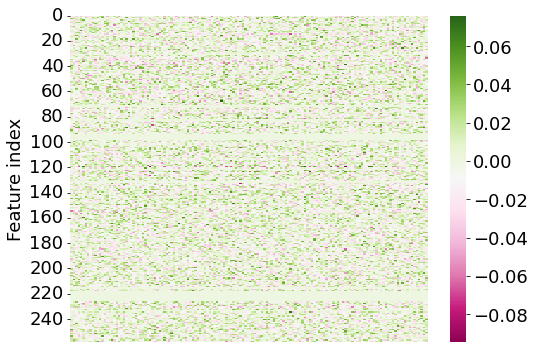

In [28]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight, cmap='PiYG')
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()

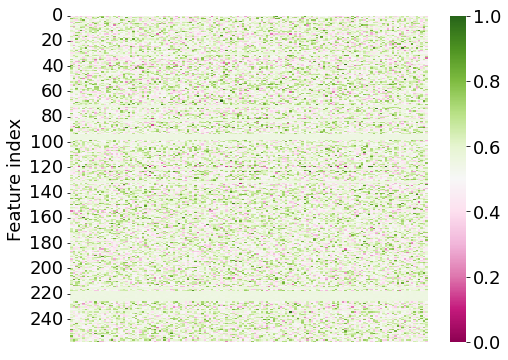

In [29]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()
first_layer_weight_scaled = (first_layer_weight - mn) / (mx - mn)

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight_scaled, cmap='PiYG', vmin=0, vmax=1)
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()